### Dividend Capture Strategy Agent with Random Forest

In this project, i will create the environment and an RL agent that learns to choose the best scheme of dividend investing given a dividend calendar and up-to-date market data.

Importing libraries

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, re #, xlrd
import datetime, pickle, math#, openpyxl
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import precision_score, recall_score, make_scorer

import random, time

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
#from env_LR import market
from env_classification import market

In [4]:
training_cols2=['Due_Dividend', 'p_Open', 'p_High', 'p_Low', 'p_Close', 'p2_Close', 'p_Volume', 'Dividend/p_Pc', 'Weekday', 'Month',
 'Week', 'p_Open/p_Close', 'p_Low/p_Close', 'p_High/p_Close', 'Open/p_Close', 'p2_Close/p_Close', 'TTO', 'TTO_MA5', 'TTO_MA45', 'ATTO_5',
 'ATTO_45', 'Beta_22', 'Beta_64', 'MACD_short', 'MACD_Signal_short', 'MACD_hist_short', 'MACD_long', 'MACD_Signal_long',  'MACD_hist_long', 'PPO_short', 'PPO_long', 'Momentum_long', 'Momentum_short', 'StochFast_K', 'StochFast_D', 'StochSlow_K',  'StochSlow_D', 'RSI', 'Williams_R', 'ADO', 'OBV', 'CCI', 'Bias', '10_day_SMA/p_Close', '12_day_EMA/p_Close', '10_day_WMA/p_Close',
 '10_day_SMA', '12_day_EMA', '10_day_WMA', 'Quarter_1', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Rel_ExDD_-3', 'Rel_ExDD_-2',  'Rel_ExDD_-1', 'Rel_ExDD_Invalid']

In [4]:
#Track total reward per episode and check for stability which indicated convergence
all_episode_portfolio=[] #saving the portfolio value at end of each episode
all_episode_rewards=[] #reward at end of each episode
all_actions=[]
all_episode_dividends=[]

In [5]:
#Finding the right decay rate
#I observed an average of xxx steps per episode. I want to reduce the epsilon to minimum value by the 3 million-th episode.
#Hence, i will design the below decay rate where epsilon >0.5 for approximately 30% of the episodes
#episodes_counts = np.arange(0,100)
#epsilon = []
#for i in range(0,100):
#    epsilon.append(0 + (1 - 0) * np.exp(-0.028*i))

#plt.plot(episodes_counts, epsilon)
#plt.axhline(y=0.5, color='r', linestyle=':')
#plt.axvline(x=25, color='g', linestyle=':')
#plt.show()

In [6]:
class RFAgent:
    def __init__(self):

        # create model
        self.model = self.build_model()

        # lists for the states, actions and rewards
        self.states, self.actions, self.rewards = [], [], []
        
        #Set epsilon for decay
        self.epsilon_max = 1.0
        self.epsilon_decay = np.exp(-0.028) 
        self.epsilon_min = 0.00000001      
        self.epsilon=self.epsilon_max
    
    def build_model(self):
        model = RandomForestClassifier(n_estimators=800, criterion='gini', max_depth=5, max_features='auto', 
                          random_state=40, class_weight='balanced')
        return model
    
    def get_action(self, state, encoded_state, episode):
        valid_actions=env.get_valid_actions(state)
        valid_actions_idx=[env.action_space.index(i) for i in valid_actions]
        z=np.random.rand()
        if (z <= self.epsilon) or (episode<1):                         #if z<=epsilon, then go exploration; select random action from all possible actions
            return valid_actions[random.randrange(len(valid_actions))]#,exploration_counter
        else:                                         #if z>epsilon, then go exploitation; select best action from all possible actions
            valid_actions.pop(-1) #since -1 action is built into the below code
            valid_actions_idx=[env.action_space.index(i) for i in valid_actions]
            pred_prob=self.model.predict_proba(encoded_state)
            profit_idx=list(self.model.classes_).index('Profit')
            profit_prob=[element[profit_idx] for element in pred_prob]
            valid_probs=[profit_prob[i] for i in valid_actions_idx]
            if max(valid_probs, default=0)>0.5:
                return valid_actions[np.argmax(valid_probs)]
            else:
                return -1
    
    def get_action_test(self, state, encoded_state, episode):    
        valid_actions=env.get_valid_actions(state)
        valid_actions.pop(-1) #since -1 action is built into the below code
        valid_actions_idx=[env.action_space.index(i) for i in valid_actions]
        pred_prob=self.model.predict_proba(encoded_state)
        profit_idx=list(self.model.classes_).index('Profit')
        profit_prob=[element[profit_idx] for element in pred_prob]
        valid_probs=[profit_prob[i] for i in valid_actions_idx]
        if max(valid_probs, default=0)>0.5:
            return valid_actions[np.argmax(valid_probs)]
        else:
            return -1
    
    # save <s, a ,r> of each step
    def append_sample(self, state, action, reward):
        self.states.append(state)
        self.rewards.append(reward)
        self.actions.append(action)
        
        # Decay in ε after we generate each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # update policy network every episode
    def train_model(self):
        # For every (s,a,r) appended, filter dataframe in s for ticker 'a'; concat this for all appended samples to make X_train
        # rewards is a list of labels and is used as y_train
        x_train_list=[]
        y_train_list=[]
        
        for idx in range(len(self.states)):
            s1=self.states[idx][0].copy() 
            a1=self.actions[idx]
            if a1!=-1: #choosing only the states where the action of buying happened
                x_train_list.append(s1[s1.ticker==a1][training_cols2]) #select only training_cols
                y_train_list.append(self.rewards[idx])

        X_train=pd.concat(x_train_list)
        X_train.reset_index(inplace=True, drop=True)
        y_train=pd.Series(y_train_list)
        
        self.model.fit(X_train,y_train)
        self.states, self.actions, self.rewards = [], [], []

In [5]:
#Initialize environment
env=market()
# Defining number of episodes to train
EPISODES = 60

In [8]:
#Initialize agent
agent = RFAgent()
triggers=[0,0,0,0,0,0,0]
all_step_rewards=[]
all_triggers=[]

In [9]:
start_time = time.time()

for episode in tqdm_notebook(range(EPISODES)):
    # Write code here
    terminal_state=False
    #month_dividend=0
    episode_steps=0
    episode_reward=0
    episode_dividend=0

    state = env.reset()
    investment=state[1]
    portfolio=investment

    while not terminal_state:
        state_encod=env.state_encoder(state)
        
        # get action for the current state and go one step in environment
        action = agent.get_action(state,state_encod, episode) 
        
        next_state, label, reward, dividend, trig_count = env.action_success_fn(action,state)
        episode_reward+=reward
        episode_steps+=1
        episode_dividend+=dividend
        
        triggers[0]+=trig_count[0]
        triggers[1]+=trig_count[1]
        triggers[2]+=trig_count[2]
        triggers[3]+=trig_count[3]
        triggers[4]+=trig_count[4]
        triggers[5]+=trig_count[5]
        triggers[6]+=trig_count[6]

        # save the sample <s, a, r> 
        agent.append_sample(state, action, label)

        state = next_state
        
        if (env.get_date(state)>=pd.to_datetime(datetime.date(2019,1,1))) or (investment+episode_reward<=0.5*investment): #or (episode_steps>=23) : 
            #episodes are limited upto 1 Jan 2019 only or 50% drop in portfolio value
            terminal_state=True
            
    if terminal_state:
        agent.train_model()    
        portfolio+=episode_reward
        all_episode_rewards.append(episode_reward) #saving the reward at end of each episode
        all_episode_portfolio.append(portfolio)
        all_triggers.append(triggers)
        all_episode_dividends.append(episode_dividend)
    
    if (episode+1)%1==0:
        episode_count=episode+1
        elapsed_time = time.time() - start_time
        #print(random_action_count/total_steps_count)
        print('Episode:{},Epsilon:{}, Episode Steps:{},Episode Reward:{},Portfolio:{},Episode Dividend:{},Triggers:{}, Actions:{}'.
              format(episode_count,round(agent.epsilon,2),episode_steps,round(episode_reward,2),round(portfolio,2),round(episode_dividend,2),triggers,sum(triggers)))
    triggers=[0,0,0,0,0,0,0]

Episode:1,Epsilon:0.0, Episode Steps:1193,Episode Reward:0.51,Portfolio:1.51,Episode Dividend:1.27,Triggers:[460, 26, 182, 20, 225, 157, 1], Actions:1071
Episode:2,Epsilon:0.0, Episode Steps:1193,Episode Reward:3.4,Portfolio:4.4,Episode Dividend:3.54,Triggers:[373, 14, 261, 21, 319, 205, 0], Actions:1193
Episode:3,Epsilon:0.0, Episode Steps:1193,Episode Reward:2.01,Portfolio:3.01,Episode Dividend:3.38,Triggers:[474, 34, 219, 23, 266, 174, 2], Actions:1192
Episode:4,Epsilon:0.0, Episode Steps:1193,Episode Reward:3.77,Portfolio:4.77,Episode Dividend:3.79,Triggers:[319, 8, 298, 11, 321, 236, 0], Actions:1193
Episode:5,Epsilon:0.0, Episode Steps:1193,Episode Reward:1.28,Portfolio:2.28,Episode Dividend:3.1,Triggers:[495, 34, 198, 16, 249, 196, 3], Actions:1191
Episode:6,Epsilon:0.0, Episode Steps:1193,Episode Reward:3.22,Portfolio:4.22,Episode Dividend:3.53,Triggers:[478, 34, 225, 20, 264, 172, 0], Actions:1193
Episode:7,Epsilon:0.0, Episode Steps:1193,Episode Reward:2.74,Portfolio:3.74,Epi

Episode:55,Epsilon:0.0, Episode Steps:1193,Episode Reward:1.55,Portfolio:2.55,Episode Dividend:3.25,Triggers:[509, 24, 206, 22, 248, 180, 3], Actions:1192
Episode:56,Epsilon:0.0, Episode Steps:1193,Episode Reward:3.14,Portfolio:4.14,Episode Dividend:3.56,Triggers:[513, 45, 230, 21, 222, 161, 0], Actions:1192
Episode:57,Epsilon:0.0, Episode Steps:1193,Episode Reward:2.23,Portfolio:3.23,Episode Dividend:3.88,Triggers:[476, 17, 218, 24, 272, 182, 3], Actions:1192
Episode:58,Epsilon:0.0, Episode Steps:1193,Episode Reward:2.92,Portfolio:3.92,Episode Dividend:3.27,Triggers:[530, 45, 212, 17, 232, 155, 0], Actions:1191
Episode:59,Epsilon:0.0, Episode Steps:1193,Episode Reward:1.9,Portfolio:2.9,Episode Dividend:3.75,Triggers:[482, 26, 207, 27, 252, 196, 3], Actions:1193
Episode:60,Epsilon:0.0, Episode Steps:1193,Episode Reward:2.79,Portfolio:3.79,Episode Dividend:3.23,Triggers:[507, 46, 210, 17, 246, 166, 0], Actions:1192



In [30]:
#Saving pickle files; the above took 8.5 hrs to run the above 60 episodes
with open('RFCAgent_abs_rew.pickle', 'wb') as handle:
    pickle.dump(agent, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
#Saving training data

with open('Final_RFCAgent_model_abs_rew.pickle', 'wb') as handle:
    pickle.dump(agent.model, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('Final_RFCAgent_abs_rew_all_episode_rewards.pickle', 'wb') as handle:
    pickle.dump(all_episode_rewards, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('Final_RFCAgent_abs_rew_all_episode_portfolio.pickle', 'wb') as handle:
    pickle.dump(all_episode_portfolio, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('Final_RFCAgent_abs_rew_all_triggers.pickle', 'wb') as handle:
    pickle.dump(all_triggers, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('Final_RFCAgent_abs_rew_all_dividends.pickle', 'wb') as handle:
    pickle.dump(all_episode_dividends, handle, protocol=pickle.HIGHEST_PROTOCOL)

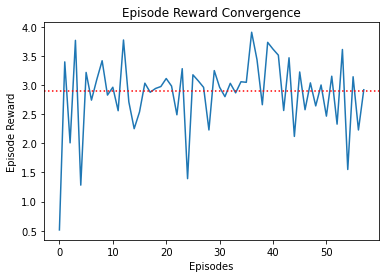

In [46]:
plt.plot(all_episode_rewards[:58])
plt.xlabel('Episodes')
plt.ylabel('Episode Reward')
plt.axhline(y=2.9, color='r', linestyle=':') #Drawing horizontal line at y=12
plt.title('Episode Reward Convergence')
plt.show()

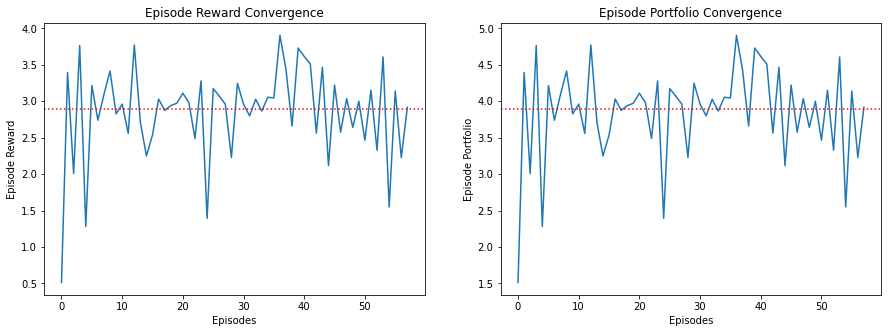

In [47]:
#These graphs are for normalized policy; nan's replaced by zero and sum of policy scaled to 1 by loading on valid actions' indices
#Gamma value of 0.9 instead of 0.1 earlier with 927 episodes: 27 hrs
plt.figure(0, figsize=(15,5))
plt.subplot(121)
plt.plot(all_episode_rewards[:58])
plt.xlabel('Episodes')
plt.ylabel('Episode Reward')
plt.axhline(y=2.9, color='r', linestyle=':') #Drawing horizontal line at y=12
plt.title('Episode Reward Convergence')
          
plt.subplot(122)
plt.plot(all_episode_portfolio[:58])
plt.xlabel('Episodes')
plt.ylabel('Episode Portfolio')
plt.axhline(y=3.9, color='r', linestyle=':') #Drawing horizontal line at y=12
plt.title('Episode Portfolio Convergence')        
          
plt.show()

**RUNNING ON TEST SET**

In [7]:
#Loading the RF model
file4 = open("Final_RFCAgent_model_abs_rew.pickle", "rb")
RFmodel = pickle.load(file4)
file4.close()

In [13]:
#Loading the ms_dict
file3 = open("market_state_scaled_dummy_dict.pickle", "rb")
ms_dict = pickle.load(file3)
file3.close()

In [14]:
test_start=[ms_dict.get(pd.to_datetime(datetime.date(2019,1,2))),1.0, {'sell_date':'cash'}]

In [15]:
#Modfiying agent code to load the saved model
class RFAgent:
    def __init__(self):

        # create model
        self.model = self.build_model()

        # lists for the states, actions and rewards
        self.states, self.actions, self.rewards = [], [], []
        
        #Set epsilon for decay
        self.epsilon_max = 1.0
        self.epsilon_decay = np.exp(-0.028) 
        self.epsilon_min = 0.00000001      
        self.epsilon=self.epsilon_max
    
    def build_model(self):
        model = RFmodel 
        return model

    def get_action(self, state, encoded_state, episode):
        valid_actions=env.get_valid_actions(state)
        valid_actions_idx=[env.action_space.index(i) for i in valid_actions]
        z=np.random.rand()
        if (z <= self.epsilon) or (episode<1):                         #if z<=epsilon, then go exploration; select random action from all possible actions
            return valid_actions[random.randrange(len(valid_actions))]#,exploration_counter
        else:                                         #if z>epsilon, then go exploitation; select best action from all possible actions
            valid_actions.pop(-1) #since -1 action is built into the below code
            valid_actions_idx=[env.action_space.index(i) for i in valid_actions]
            pred_prob=self.model.predict_proba(encoded_state)
            profit_idx=list(self.model.classes_).index('Profit')
            profit_prob=[element[profit_idx] for element in pred_prob]
            valid_probs=[profit_prob[i] for i in valid_actions_idx]
            if max(valid_probs, default=0)>0.5:
                return valid_actions[np.argmax(valid_probs)]
            else:
                return -1
    
    def get_action_test(self, state, encoded_state, episode):    
        valid_actions=env.get_valid_actions(state)
        valid_actions.pop(-1) #since -1 action is built into the below code
        valid_actions_idx=[env.action_space.index(i) for i in valid_actions]
        pred_prob=self.model.predict_proba(encoded_state)
        profit_idx=list(self.model.classes_).index('Profit')
        profit_prob=[element[profit_idx] for element in pred_prob]
        valid_probs=[profit_prob[i] for i in valid_actions_idx]
        if max(valid_probs, default=0)>0.5:
            return valid_actions[np.argmax(valid_probs)]
        else:
            return -1
    
    # save <s, a ,r> of each step
    def append_sample(self, state, action, reward):
        self.states.append(state)
        self.rewards.append(reward)
        self.actions.append(action)
        
        # Decay in ε after we generate each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train_model(self):
        # For every (s,a,r) appended, filter dataframe in s for ticker 'a'; concat this for all appended samples to make X_train
        # rewards is a list of labels and is used as y_train
        x_train_list=[]
        y_train_list=[]
        
        for idx in range(len(self.states)):
            s1=self.states[idx][0].copy() 
            a1=self.actions[idx]
            if a1!=-1: #choosing only the states where the action of buying happened
                x_train_list.append(s1[s1.ticker==a1][training_cols2]) #select only training_cols
                y_train_list.append(self.rewards[idx])

        X_train=pd.concat(x_train_list)
        X_train.reset_index(inplace=True, drop=True)
        y_train=pd.Series(y_train_list)
        
        self.model.fit(X_train,y_train)
        self.states, self.actions, self.rewards = [], [], []

In [16]:
agent = RFAgent()

In [17]:
#Running model on test data
test_trig2=[0,0,0,0,0,0,0]
episode_steps2=0
episode_reward2=0
episode_dividend2=0
test_rewards2=[]
test_portfolios2=[]
#set to state corresponding to first trading day after 1/1/2019 at start of episode, state is [dataframe,array]
test_state = test_start
test_investment=test_state[1]
test_portfolio2=test_investment
step_actions2=[]

while (env.get_date(test_state)<=pd.to_datetime(datetime.date(2021,12,31))):#only or upto 31 Dec 2021
        
    state_encod=env.state_encoder(test_state)
        
    # get action for the current state and go one step in environment
    action = agent.get_action_test(test_state,state_encod,2) 
    step_actions2.append(action)
    
    next_state, label, reward, dividend, trig_count = env.action_success_fn(action,test_state)
    episode_reward2+=reward
    episode_steps2+=1
    episode_dividend2+=dividend
        
    test_trig2[0]+=trig_count[0]
    test_trig2[1]+=trig_count[1]
    test_trig2[2]+=trig_count[2]
    test_trig2[3]+=trig_count[3]
    test_trig2[4]+=trig_count[4]
    test_trig2[5]+=trig_count[5]
    test_trig2[6]+=trig_count[6]

    test_state = next_state
    #print(test_state[1])
    test_portfolio2+=reward
    test_rewards2.append(reward) #saving the reward at end of each episode
    test_portfolios2.append(test_portfolio2)

In [15]:
'ARR of model with RFC agent after 60 episodes is {}%'.format(round(((((test_portfolio2)/1)**(1/3)-1)*100),2))

'ARR of model with RFC agent after 60 episodes is 31.21%'

In [48]:
t=36/3
model_returns=[t*((test_portfolios2[i])**(21/i)-1) for i in range(21,757,21)]
len(model_returns)

36

In [49]:
(test_portfolios2[-1]**(1/3)-1)

0.31213852644516527

In [51]:
#Sharpe Ratio
((test_portfolios2[-1]**(1/3)-1)-0.0117)/np.std(model_returns)

4.221374260889137

In [52]:
print('There are {} trading days in test set. The agent chooses to trade on {} days only.'.format(episode_steps2,np.sum(test_trig2)))

There are 757 trading days in test set. The agent chooses to trade on 757 days only.


In [53]:
print('The total dividend captured by the agent is {} while the total profit in final portfolio at end of 3 years is {}.\nThis indicates that majority of the profits are captured from dividends while trading related losses bring it down. Despite this, the agent outperforms the S&P500 by more than 800 bps.'
      .format(round(episode_dividend2,2),round(test_portfolio2-1,2)))

The total dividend captured by the agent is 1.34 while the total profit in final portfolio at end of 3 years is 1.26.
This indicates that majority of the profits are captured from dividends while trading related losses bring it down. Despite this, the agent outperforms the S&P500 by more than 800 bps.


In [17]:
test_rewards2.index(max(test_rewards2))

272

In [18]:
test_rewards2[272]

0.26217111330223203

In [19]:
'ARR of model without the outlier dividend payment in test set is {}% which also beats the S&P500 ARR for same time period'.format(round(((((test_portfolio2-test_rewards2[272])/1)**(1/3)-1)*100),2))

'ARR of model without the outlier dividend payment in test set is 25.93% which also beats the S&P500 ARR for same time period'

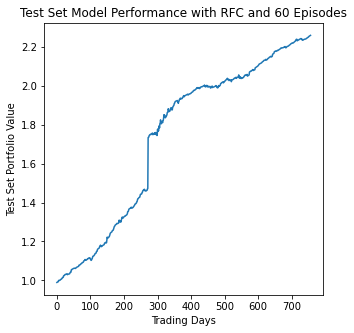

In [20]:
#Tracking inidividual episode total reward to check convergence
plt.figure(figsize=(5,5))
plt.plot(test_portfolios2)
#plt.axhline(y=1800, color='r', linestyle=':') #Drawing horizontal line at y=1800
plt.xlabel('Trading Days')
plt.ylabel('Test Set Portfolio Value')
plt.title('Test Set Model Performance with RFC and 60 Episodes')
plt.show()

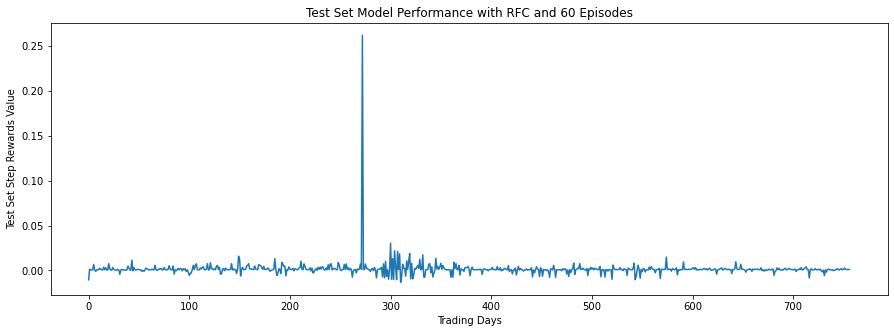

In [21]:
#Tracking inidividual episode total reward to check convergence
plt.figure(figsize=(15,5))
plt.plot(test_rewards2)
#plt.axhline(y=1800, color='r', linestyle=':') #Drawing horizontal line at y=1800
plt.xlabel('Trading Days')
plt.ylabel('Test Set Step Rewards Value')
plt.title('Test Set Model Performance with RFC and 60 Episodes')
plt.show()

In [63]:
test_trig2

[311, 20, 164, 26, 129, 107, 0]

In [103]:
pd.Series(test_rewards2).describe()

count    757.000000
mean       0.003924
std        0.014289
min       -0.040000
25%        0.003615
50%        0.004000
75%        0.008631
max        0.087952
dtype: float64

In [55]:
#saving portfolio values on test set as excel file
pd.DataFrame(test_portfolios2).to_excel("rfc_test.xlsx") 

In [60]:
#Building feature importance matrix
fim=pd.DataFrame({'coeff':list(agent.model.feature_importances_), 'feature_name':list(agent.model.feature_names_in_)})

In [61]:
fim['abs_coeff']=abs(fim.coeff)

In [62]:
fim.sort_values(by='abs_coeff', ascending=False)

,coeff,feature_name,abs_coeff
7,0.081474,Dividend/p_Pc,0.081474
0,0.033581,Due_Dividend,0.033581
37,0.031793,RSI,0.031793
55,0.026823,Rel_ExDD_-1,0.026823
13,0.025377,p_High/p_Close,0.025377
36,0.023478,StochSlow_D,0.023478
35,0.023380,StochSlow_K,0.023380
34,0.023195,StochFast_D,0.023195
26,0.022303,MACD_long,0.022303
33,0.021903,StochFast_K,0.021903


In [11]:
#Always losing in training data but not in test data
for ticker in ['VST','DOW','FOXA','CTVA','YY','RPRX']:
    print('Agent bought {} {} times from 2019 to 2021'.format(ticker, step_actions2.count(ticker)))

Agent bought VST 4 times from 2019 to 2021
Agent bought DOW 4 times from 2019 to 2021
Agent bought FOXA 2 times from 2019 to 2021
Agent bought CTVA 0 times from 2019 to 2021
Agent bought YY 3 times from 2019 to 2021
Agent bought RPRX 1 times from 2019 to 2021


In [12]:
#Always winning in training data but not in test data
for ticker in ['GSK','SAP','NLY','AZN','PGR','NVS','NTR']:
    print('Agent bought {} {} times from 2019 to 2021'.format(ticker, step_actions2.count(ticker)))

Agent bought GSK 2 times from 2019 to 2021
Agent bought SAP 1 times from 2019 to 2021
Agent bought NLY 8 times from 2019 to 2021
Agent bought AZN 3 times from 2019 to 2021
Agent bought PGR 6 times from 2019 to 2021
Agent bought NVS 3 times from 2019 to 2021
Agent bought NTR 4 times from 2019 to 2021
